# **SSCS - Test Playground**

Developed by André Paiva

Based on SSCS Dataset created by Helena Cuesta and Emilia Gómez

## 01 - Import modules

In [13]:
import os
import json
import numpy as np
import pandas as pd
import zipfile
import matplotlib as mpl
import matplotlib.pyplot as plt
from urllib.request import urlopen
import shutil
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Flatten

## 02 - Neural Network Model (VoasCNN)

In [14]:
SAVE_MODEL = True
LOAD_MODEL = True
MAX_LENGTH_TRAINING = 128

In [15]:
def voas_cnn():
    x_in = Input(shape=(360, MAX_LENGTH_TRAINING, 1))
    
    x = BatchNormalization()(x_in)

    x = Conv2D(filters=32, kernel_size=(3, 3), padding="same",
        activation="relu", name="conv1")(x)

    x = BatchNormalization()(x)

    x = Conv2D(filters=32, kernel_size=(3, 3), padding="same",
        activation="relu", name="conv2")(x)

    x = BatchNormalization()(x)

    x = Conv2D(filters=16, kernel_size=(70, 3), padding="same",
        activation="relu", name="conv_harm_1")(x)

    x = BatchNormalization()(x)

    x = Conv2D(filters=16, kernel_size=(70, 3), padding="same",
        activation="relu", name="conv_harm_2")(x)

    ## start four branches now

    x = BatchNormalization()(x)

    ## branch 1
    x1a = Conv2D(filters=16, kernel_size=(3, 3), padding="same",
        activation="relu", name="conv1a")(x)

    x1a = BatchNormalization()(x1a)

    x1b = Conv2D(filters=16, kernel_size=(3, 3), padding="same",
        activation="relu", name="conv1b")(x1a)

    ## branch 2
    x2a = Conv2D(filters=16, kernel_size=(3, 3), padding="same",
        activation="relu", name="conv2a")(x)

    x2a = BatchNormalization()(x2a)

    x2b = Conv2D(filters=16, kernel_size=(3, 3), padding="same",
        activation="relu", name="conv2b")(x2a)

    ## branch 3

    x3a = Conv2D(filters=16, kernel_size=(3, 3), padding="same",
        activation="relu", name="conv3a")(x)

    x3a = BatchNormalization()(x3a)

    x3b = Conv2D(filters=16, kernel_size=(3, 3), padding="same",
        activation="relu", name="conv3b")(x3a)

    x4a = Conv2D(filters=16, kernel_size=(3, 3), padding="same",
        activation="relu", name="conv4a")(x)

    x4a = BatchNormalization()(x4a)

    x4b = Conv2D(filters=16, kernel_size=(3, 3), padding="same",
        activation="relu", name="conv4b"
    )(x4a)


    y1 = Conv2D(filters=1, kernel_size=1, name='conv_soprano',
                padding='same', activation='sigmoid')(x1b)
    y1 = tf.squeeze(y1, axis=-1)
    y2 = Conv2D(filters=1, kernel_size=1, name='conv_alto',
                padding='same', activation='sigmoid')(x2b)
    y2 = tf.squeeze(y2, axis=-1)
    y3 = Conv2D(filters=1, kernel_size=1, name='conv_tenor',
                padding='same', activation='sigmoid')(x3b)
    y3 = tf.squeeze(y3, axis=-1)
    y4 = Conv2D(filters=1, kernel_size=1, name='conv_bass',
                padding='same', activation='sigmoid')(x4b)
    y4 = tf.squeeze(y4, axis=-1)

    out = [y1, y2, y3, y4]

    model = Model(inputs=x_in, outputs=out, name='voasCNN')

    return model

## 03 - Auxiliar functions

Functions designed to manipulate the SSCS dataset.

In [16]:
pathname = "Datasets"
zipname = pathname + "/SynthSalienceChoralSet_v1.zip"
splitname = pathname + "/SynthSalienceChoralSet_dataSplits.json"

def sscs_download():
    if(not os.path.exists(pathname)):
        os.mkdir(pathname)
    if(not os.path.exists(zipname)):
        url = "https://zenodo.org/record/6534429/files/SynthSalienceChoralSet_v1.zip?download=1"
        with urlopen(url) as response, open(zipname, 'wb') as out_file:
            shutil.copyfileobj(response, out_file)
    if(not os.path.exists(splitname)):
        url = "https://raw.githubusercontent.com/helenacuesta/voas-vocal-quartets/main/data/data_splits_hpc.json"
        with urlopen(url) as response, open(splitname, 'wb') as out_file:
            shutil.copyfileobj(response, out_file)

def sscs_read_metadata():
    with zipfile.ZipFile(zipname) as zf:
        with zf.open('sscs_metadata.csv') as f:
            df = pd.read_csv(f)
            return df

def sscs_read_voice(name, voice):
    filename = 'sscs/' + name + "_"
    if(voice.upper() == 'S' or voice.upper() == 'A' or \
       voice.upper() == 'T' or voice.upper() == 'B'):
        filename = filename + voice.upper()
    elif(voice.lower() == 'mix'):
        filename = filename + voice.lower()
    else:
        raise NameError("Specify voice with 'S', 'A', 'T', 'B' or 'mix'.")
    filename = filename + ".csv"
    with zipfile.ZipFile(zipname) as zf:
        with zf.open(filename) as f:
            df = pd.read_csv(f, header=None)
    return df

def sscs_read_all_voices(name):
    df_mix = sscs_read_voice(name, 'mix')
    df_s = sscs_read_voice(name, 'S')
    df_a = sscs_read_voice(name, 'A')
    df_t = sscs_read_voice(name, 'T')
    df_b = sscs_read_voice(name, 'B')
    return df_mix, df_s, df_a, df_t, df_b

def sscs_get_split(split='train'):
    if(split.lower() == 'train' or split.lower() == 'validate' or
       split.lower() == 'test'):
        return json.load(open(splitname, 'r'))[split.lower()]
    else:
        raise NameError("Split should be 'train', 'validate' or 'test'.")

def sscs_pick_random_song(split='train'):
    songnames = sscs_get_split(split)
    rng = np.random.randint(0, len(songnames))
    return songnames[rng]

def sscs_plot(dataframe):
  aspect_ratio = (3/8)*dataframe.shape[1]/dataframe.shape[0]
  fig, ax = plt.subplots(figsize=(13, 7))
  im = ax.imshow(dataframe, interpolation='nearest', aspect=aspect_ratio,
                 cmap = mpl.colormaps['BuPu'])
  ax.invert_yaxis()
  plt.show()

def sscs_plot_random(voice, split='train'):
    sscs_plot(sscs_read_voice(sscs_pick_random_song(split), voice))

## 04 - Download dataset SSCS

In [17]:
sscs_download()

## 05 - Pick random song and plot mix pitch saliences

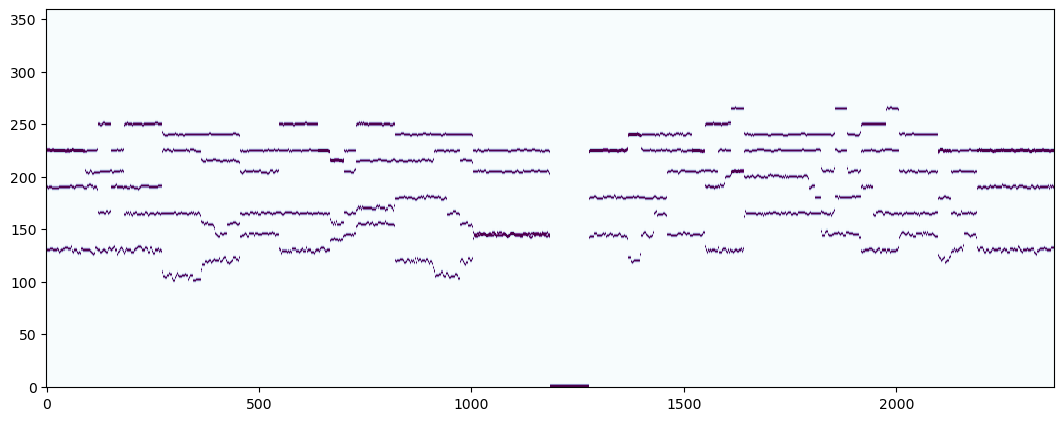

In [18]:
sscs_plot_random('mix')

## 06 - Training VoasCNN